# Data Analysis in Geoscience Remote Sensing Projects: Exercises
## Final task handed in by: SUDUR BHATTARAI (MSRSGI, Student number: 2514652) on DATE: 19.02.2024
Hendrik Andersen, contact: hendrik.andersen@kit.edu

## Part one: Regression and sensitivity estimation with remote sensing 

For this part you are provided with a data set contained in the file 'data_final_task_regression.csv'. The data contains information on regional averages of low-cloud occurrence and meteorological factors in the Southeast Atlantic (10°S-20°S, 0°E-10°E - this means that the study area is about 1000 km x 1000 km large). The DataFrame contains the following variables:
- sst: sea surface temperature
- eis: estimated inversion strength
- t_adv: temperature advection
- w700: vertical pressure velocity at 700 hPa (this is the vertical wind speed, given in Pa/s: positive numbers mean subsiding air masses)
- rhft: relative humidity in the free troposphere (free troposphere is above the cloud layer)
- clf: Liquid water cloud fraction

The data on clouds are from a satellite data set from the MODIS sensor on board NASA's Terra satellite. The product name is MOD08_M3, downloaded from https://ladsweb.modaps.eosdis.nasa.gov/ for more information check out https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/products/MOD08_M3/#overview

The meteorological data are ERA5 reanalysis data on meteorological factors thought to be important for low cloud cover. The data is downloaded from https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview

For more information on how reanalysis data are generated, check out the 2-minute video from Copernicus ECMWF here: https://www.youtube.com/watch?v=FAGobvUGl24

Your task is to analyze the data to
1. quantitatively and visually describe the data 
2. analyze relationships between cloud fraction and the cloud-controlling factors using
    - regression analysis
    - a machine learning model (e.g. feature importance, SHAP)
3. describe the results of your analyses in the provided markdown cells. Are your results in agreement with the described relationships in the following study?: Klein et al. (2017): Low-Cloud Feedbacks from Cloud-Controlling Factors: A Review, Surveys in Geophysics, doi: 10.1007/s10712-017-9433-3

## Part two: Classification in a remote sensing retrieval setting

For the second part of the exercise, you are tasked to develop a machine learning method to detect fog and low clouds for a location in the Namib Desert on the basis of observations from a geostationary satellite platform. You are provided a data set (ILIAS: 'data_final_task_classification.csv') of night-time satellite observations at different wave lengths over a meteorological measurement station. The geostationary satellite (Spinning Enhanced Visible and Infrared Imager; SEVIRI) makes a scan every 15 minutes at a spatial resolution of 3km x 3km. For the exact time steps of the satellite observations made available here, a boolean (True/False) data set on the presence of fog and low clouds from the measurement station is provided, which should be used as the labeled target data.
- IR_016: Measurements at the 1.6 µm channel
- IR_039: Measurements at the 3.9 µm channel
- IR_087: Measurements at the 8.7 µm channel
- IR_097: Measurements at the 9.7 µm channel
- IR_108: Measurements at the 10.8 µm channel
- IR_120: Measurements at the 12.0 µm channel
- IR_134: Measurements at the 13.4 µm channel
- station_fls: A boolean (True/False) information if fog or low clouds are present at the given time

Your task is to analyze the data to
1. Train and optimize a machine learning classifier (e.g. GradientBoostingClassifier) to detect fog and low clouds and analyze the results using a confusion matrix and using performance metrics
2. Compare the results to a logistic regression approach, and discuss  in the provided markdown cell which method is better at classifying fog and low cloud presence/absence
3. Compare the results to a dedicated detection approach developed for the region in Andersen and Cermak (2018): First fully diurnal fog and low cloud satellite detection reveals life cycle in the Namib, Atmospheric Measurement Techniques, doi: 10.5194/amt-11-5461-2018. Use the provided markdown cell for the discussion.

You can find more specific tasks in the cells below


---------------
----------------

## Part one: Regression and sensitivity estimation with remote sensing data
__Task__: 
In a typical scientific workflow, the first step is to get an overview of the data. Typically, visualizations and descriptive statistics are very useful to achieve this.  
1. Calculate the mean and standard deviation of cloud fraction and plot the distribution of cloud fraction in a histogram.
2. Plot the CLF time series and describe seasonal patterns.

---------------------

In [153]:
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import pearsonr, linregress

data_df = pd.read_csv("data_final_task_regression.csv", index_col='time', parse_dates=True)
data_df

,sst,eis,t_adv,w700,rhft,clf
time,,,,,,
2001-01-01,296.16850,4.824931,-1.682254,0.022467,35.642094,0.663396
2001-02-01,297.11526,3.476827,-1.932790,0.026573,37.940147,0.605880
2001-03-01,298.15900,2.265783,-2.199120,0.031560,33.834457,0.529290
2001-04-01,298.17062,2.402812,-2.532412,0.039651,21.565330,0.464151
2001-05-01,297.06927,3.534788,-2.962148,0.037318,7.997189,0.318764
...,...,...,...,...,...,...
2020-06-01,295.68103,5.696461,-3.336127,0.031689,5.904962,0.516174
2020-07-01,294.38498,6.359473,-2.678568,0.028419,6.503685,0.563987
2020-09-01,292.41327,9.211763,-3.231832,0.036699,22.365800,0.865068


### Part 1 - 1. Calculate the mean and standard deviation of cloud fraction and plot the distribution of cloud fraction in a histogram.

In [136]:
print("Mean of cloud fraction: ",data_df.clf.mean())
print("Standard deviation of cloud fraction: ",data_df.clf.std())

Mean of cloud fraction:  0.6522455561224002
Standard deviation of cloud fraction:  0.15539470716409962


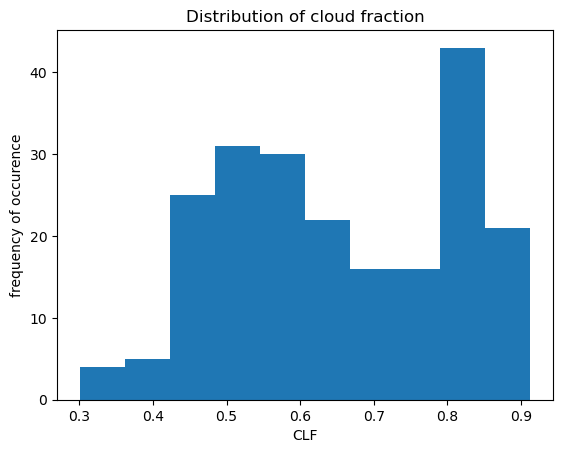

In [137]:
plt.hist(data_df.clf)
plt.title('Distribution of cloud fraction')
plt.xlabel('CLF')
plt.ylabel('frequency of occurence')
plt.show()

------------------

### Part 1 - 2. Plot the CLF time series and describe seasonal patterns.

<Axes: xlabel='Time', ylabel='Monthly average CLF'>

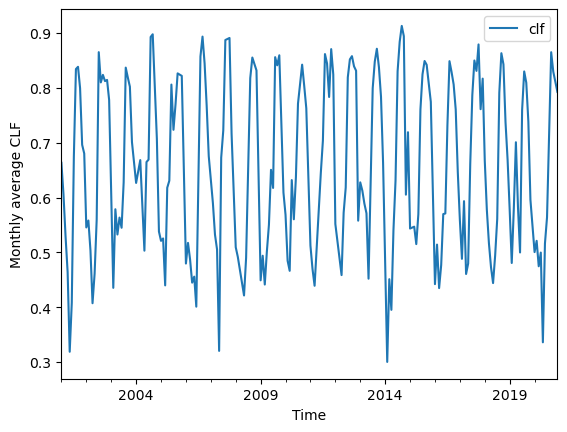

In [138]:
data_df = data_df.drop(['sst','eis','t_adv','w700','rhft'], axis = 1)
data_df_resampled = data_df.resample('m').mean()
data_df_resampled['clf'] = data_df_resampled['clf'].interpolate() # interpolate the missing values

data_df_resampled.plot(xlabel='Time', ylabel='Monthly average CLF')

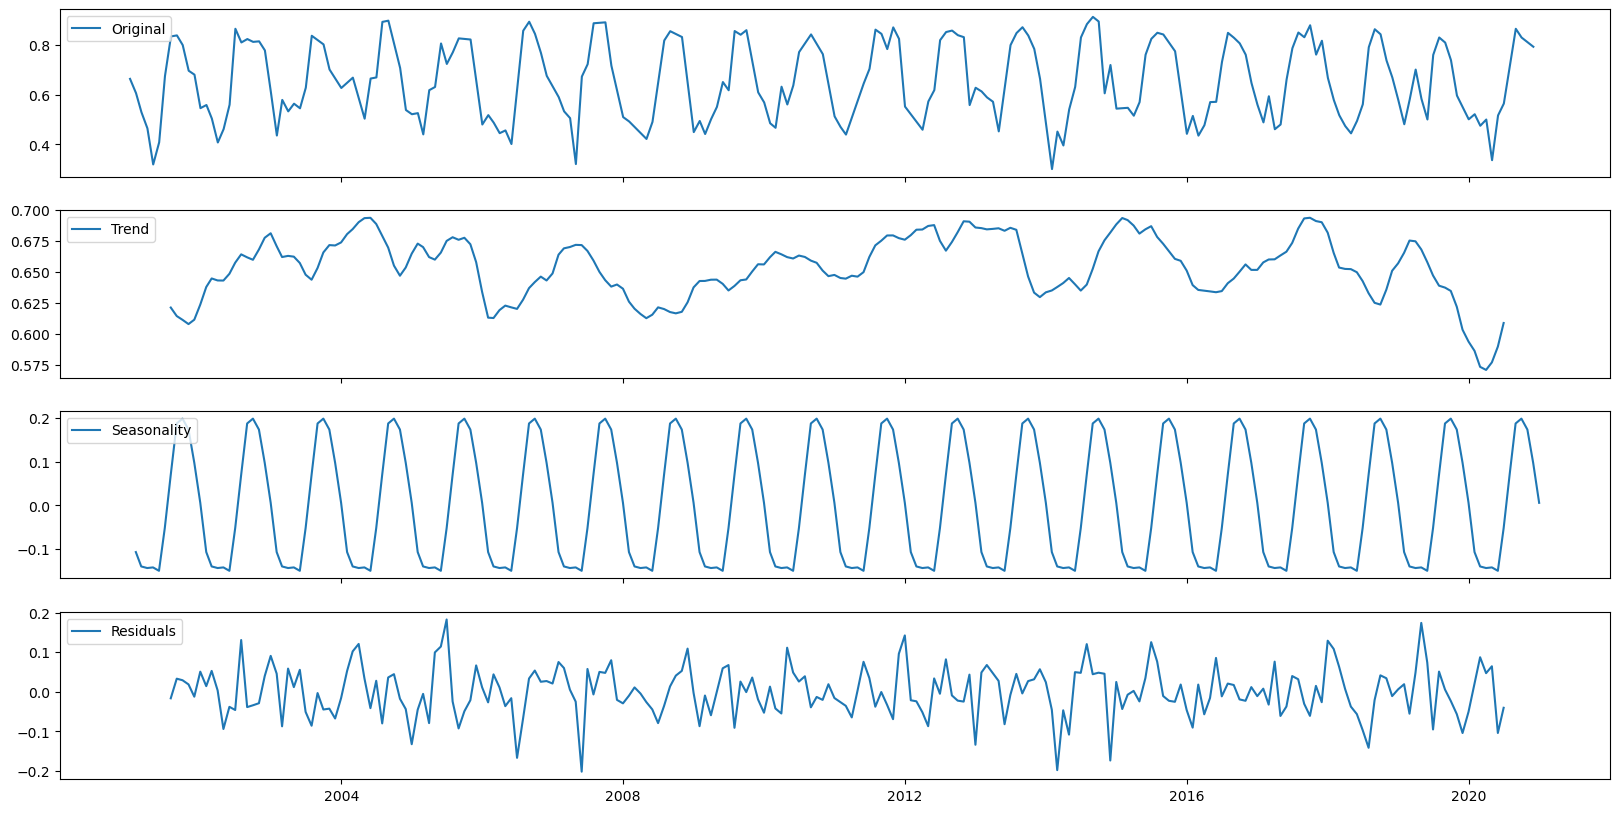

In [139]:
# the package statsmodels has a nice function to directly decompose time series. 
from statsmodels.tsa.seasonal import seasonal_decompose
ts_decomp = seasonal_decompose(x=data_df_resampled, model='additive', period = 12) # we set the cyclic period of the seasonal cycle by hand
trend_estimate = ts_decomp.trend
seasonal_estimate = ts_decomp.seasonal
residual_estimate = ts_decomp.resid

# Plotting the time series and its individual components together
fig, ax = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(20)

ax[0].plot(data_df.clf, label='Original') 
ax[0].legend(loc='upper left');

ax[1].plot(trend_estimate, label='Trend')
ax[1].legend(loc='upper left');

ax[2].plot(seasonal_estimate, label='Seasonality')
ax[2].legend(loc='upper left');

ax[3].plot(residual_estimate, label='Residuals')
ax[3].legend(loc='upper left');

With the decomposed data, we can directly see:
1. The underlying fluctuating trend: due to fluctuations in aerosol concentrations due to the natural events, e.g., Sahara dust outbreaks or antropogenic industrial pollution
2. The seasonal cycle: Southeast Atlantic region experiences distinct wet and dry season, which leads to this seasonal pattern.
3. The residual: this is related to other processes not captured by the trend and seasonal cycle
------------------
-------------------

__Task__: 
1. Compute a regression analysis of CLF with each meteorological predictor
2. Describe the sensitivities of CLF to the meteorological predictors:
    - How sensitive are low clouds to changes in meteorological predictors (in individual simple regression models, and in a multiple regression framework)?
    - Are the relationships significant?
    - Are there strong correlations between the different predictors that could influence the sensitivity estimates?
  
For the multiple linear regression, you want to be able to compare the sensitivity estimates of the different predictors (to see which ones are most important). To do this, the predictors need to be on the same scale. This is done in the code cell below by using the standard scaler (it subtracts the mean and divides by a standard deviation, so that all predictors in X have a mean value of 0 and unit variance).

---------------

## Solution - Simple Linear Regression:

2.1 - The slope of the regression line is also called "regression coefficent" and can be understood as the sensitivity of the low clouds to the changes in the metrologicala predictors, which are calculated below.

2.2 - To check the significance of the relationship, significance at 95% level has been checked. If it is true, the relationship is significant and if the significance check is false, the relationship is not significant.

In [140]:
data_df = pd.read_csv("data_final_task_regression.csv", index_col='time', parse_dates=True)
data_df

,sst,eis,t_adv,w700,rhft,clf
time,,,,,,
2001-01-01,296.16850,4.824931,-1.682254,0.022467,35.642094,0.663396
2001-02-01,297.11526,3.476827,-1.932790,0.026573,37.940147,0.605880
2001-03-01,298.15900,2.265783,-2.199120,0.031560,33.834457,0.529290
2001-04-01,298.17062,2.402812,-2.532412,0.039651,21.565330,0.464151
2001-05-01,297.06927,3.534788,-2.962148,0.037318,7.997189,0.318764
...,...,...,...,...,...,...
2020-06-01,295.68103,5.696461,-3.336127,0.031689,5.904962,0.516174
2020-07-01,294.38498,6.359473,-2.678568,0.028419,6.503685,0.563987
2020-09-01,292.41327,9.211763,-3.231832,0.036699,22.365800,0.865068


In [141]:
u = data_df['sst'].resample('m').mean().interpolate()
v = data_df['eis'].resample('m').mean().interpolate()
w = data_df['t_adv'].resample('m').mean().interpolate()
x = data_df['w700'].resample('m').mean().interpolate()
y = data_df['rhft'].resample('m').mean().interpolate()
z = data_df['clf'].resample('m').mean().interpolate()

Part 1 - Task 2 - 1 - Compute a regression analysis of CLF with each meteorological predictor

Slope:  -0.06261149513320201
Intercept:  19.138485686334477
Pearson correlation coefficient :  -0.8900305406282436 
 Significant at the 95% level :  True


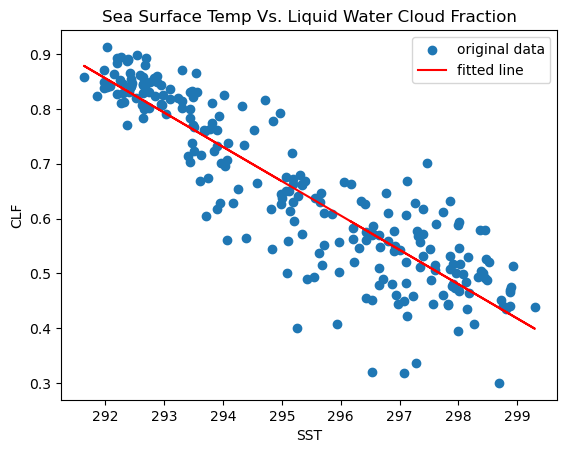

Slope:  0.05979235910446683
Intercept:  0.3072866367927005
Pearson correlation coefficient :  0.9080873869714055 
 Significant at the 95% level :  True


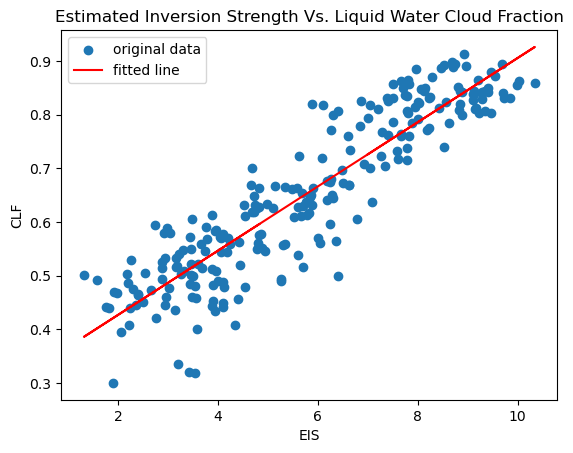

Slope:  -0.04648367664256908
Intercept:  0.5300551181596612
Pearson correlation coefficient :  -0.1657506460336463 
 Significant at the 95% level :  True


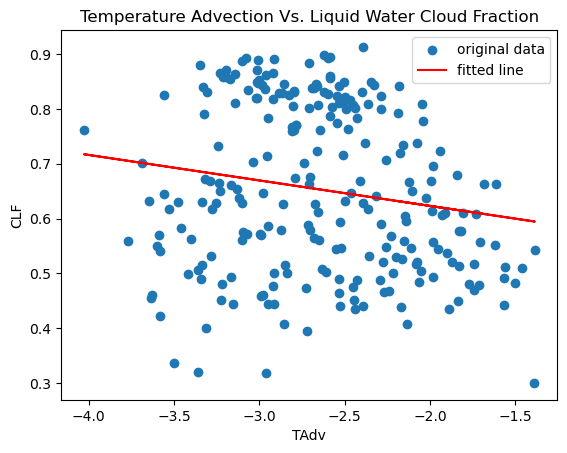

Slope:  0.5109406388668222
Intercept:  0.6351096663741431
Pearson correlation coefficient :  0.023755889708774038 
 Significant at the 95% level :  False


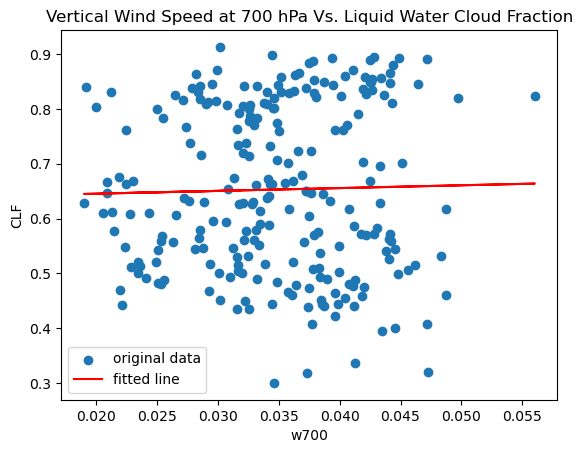

Slope:  -0.001033495766050062
Intercept:  0.6751563742727764
Pearson correlation coefficient :  -0.06479850370686883 
 Significant at the 95% level :  False


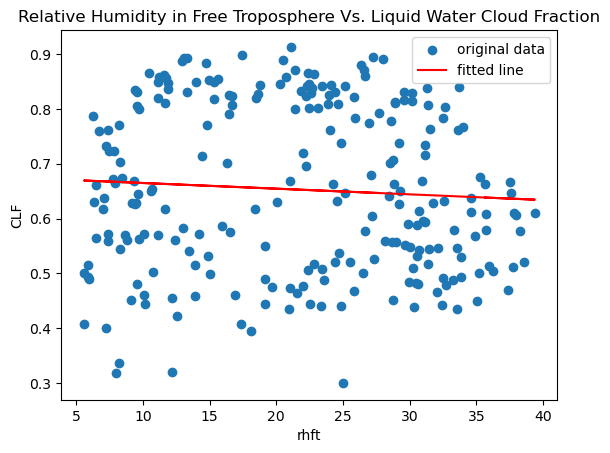

In [143]:
# Using the linregress() function from the scipy.stats module to calculate a regression line
from scipy import stats

# the function linregress() returns the slope intercept, r_value, p_value, and std_err of a regression. 
'''
# you can write your code like this  
slope, intercept, rvalue, pvalue, stderr = stats.linregress(u,z)
'''
# or like this
results_sst = stats.linregress(u,z)
# and then access e.g. the slope like so:
print("Slope: ",results_sst.slope)
print("Intercept: ",results_sst.intercept)

# now calculate the correlation coefficient after Pearson with the function imported above
r,p = pearsonr(u,z)
# The p-value is used to estimate the significance of the calculated correlation
print("Pearson correlation coefficient : ", r,"\n Significant at the 95% level : ",p < 0.05)


# Plot the resulting line above a scatterplot to visualize the result
plt.scatter(u,z, label='original data')
plt.plot(u, results_sst.intercept + results_sst.slope*u, 'r', label='fitted line')
plt.legend()
plt.xlabel('SST')
plt.ylabel('CLF')
plt.title ('Sea Surface Temp Vs. Liquid Water Cloud Fraction')
plt.legend()
plt.show()




results_eis = stats.linregress(v,z)
# and then access e.g. the slope like so:
print("Slope: ",results_eis.slope)
print("Intercept: ",results_eis.intercept)

# now calculate the correlation coefficient after Pearson with the function imported above
r,p = pearsonr(v,z)
# The p-value is used to estimate the significance of the calculated correlation
print("Pearson correlation coefficient : ", r,"\n Significant at the 95% level : ",p < 0.05)


# Plot the resulting line above a scatterplot to visualize the result
plt.scatter(v,z, label='original data')
plt.plot(v, results_eis.intercept + results_eis.slope*v, 'r', label='fitted line')
plt.legend()
plt.xlabel('EIS')
plt.ylabel('CLF')
plt.title ('Estimated Inversion Strength Vs. Liquid Water Cloud Fraction')
plt.legend()
plt.show()



results_tadv = stats.linregress(w,z)
# and then access e.g. the slope like so:
print("Slope: ",results_tadv.slope)
print("Intercept: ",results_tadv.intercept)

# now calculate the correlation coefficient after Pearson with the function imported above
r,p = pearsonr(w,z)
# The p-value is used to estimate the significance of the calculated correlation
print("Pearson correlation coefficient : ", r,"\n Significant at the 95% level : ",p < 0.05)

# Plot the resulting line above a scatterplot to visualize the result
plt.scatter(w,z, label='original data')
plt.plot(w, results_tadv.intercept + results_tadv.slope*w, 'r', label='fitted line')
plt.legend()
plt.xlabel('TAdv')
plt.ylabel('CLF')
plt.title ('Temperature Advection Vs. Liquid Water Cloud Fraction')
plt.legend()
plt.show()



results_w700 = stats.linregress(x,z)
# and then access e.g. the slope like so:
print("Slope: ",results_w700.slope)
print("Intercept: ",results_w700.intercept)

# now calculate the correlation coefficient after Pearson with the function imported above
r,p = pearsonr(x,z)
# The p-value is used to estimate the significance of the calculated correlation
print("Pearson correlation coefficient : ", r,"\n Significant at the 95% level : ",p < 0.05)

# Plot the resulting line above a scatterplot to visualize the result
plt.scatter(x,z, label='original data')
plt.plot(x, results_w700.intercept + results_w700.slope*x, 'r', label='fitted line')
plt.legend()
plt.xlabel('w700')
plt.ylabel('CLF')
plt.title ('Vertical Wind Speed at 700 hPa Vs. Liquid Water Cloud Fraction')
plt.legend()
plt.show()




results_rhft = stats.linregress(y,z)
# and then access e.g. the slope like so:
print("Slope: ",results_rhft.slope)
print("Intercept: ",results_rhft.intercept)

# now calculate the correlation coefficient after Pearson with the function imported above
r,p = pearsonr(y,z)
# The p-value is used to estimate the significance of the calculated correlation
print("Pearson correlation coefficient : ", r,"\n Significant at the 95% level : ",p < 0.05)

# Plot the resulting line above a scatterplot to visualize the result
plt.scatter(y,z, label='original data')
plt.plot(y, results_rhft.intercept + results_rhft.slope*y, 'r', label='fitted line')
plt.legend()
plt.xlabel('rhft')
plt.ylabel('CLF')
plt.title ('Relative Humidity in Free Troposphere Vs. Liquid Water Cloud Fraction')
plt.legend()
plt.show()

-----------------

## Part 1 - Task 2 - 2 - 3: Are there strong correlations between the different predictors that could influence the sensitivity estimates?

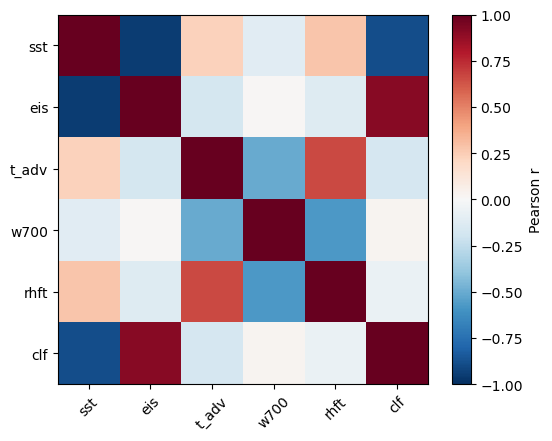

In [150]:
predictors = ['sst', 'eis', 't_adv', 'w700', 'rhft', 'clf']
corr_matrix = np.corrcoef([u,v,w,x,y,z]) # np.corrcoef can compute correlation matrices. 

plt.imshow(corr_matrix, cmap = plt.cm.RdBu_r, vmin = -1, vmax = 1)
plt.colorbar(label = 'Pearson r')
plt.xticks(np.arange(len(predictors)), predictors, rotation=45)
plt.yticks(np.arange(len(predictors)), predictors)
plt.show()

Clearly,from the above correlation matrix, we can visualize the correltion of clf to other metrological predictors such as sst, eis, t_adv, w700, and rhft. Not only we can visualize the corraltion of clf to other metrolofical predidctors, but also we can visualize the correlation among different other metrological predictors.
From the above corrlation matrix, we can see that clf is highly positively correlated to eis and highly negatively correlated to sst. So both predictors clf and eis could influence the sensitivity analysis.

-----------------


## Part 1 - Task 2 - Multiple Regression Framework

For the multiple linear regression to be able to compare the sensitivity estimates of the different predictors (to see which ones are most important), the predictors need to be on the same scale. This is done in the code cell below by using the standard scaler (it subtracts the mean and divides by a standard deviation, so that all predictors in X have a mean value of 0 and unit variance).

In [320]:
data_df

,sst,eis,t_adv,w700,rhft,clf
time,,,,,,
2001-01-01,296.16850,4.824931,-1.682254,0.022467,35.642094,0.663396
2001-02-01,297.11526,3.476827,-1.932790,0.026573,37.940147,0.605880
2001-03-01,298.15900,2.265783,-2.199120,0.031560,33.834457,0.529290
2001-04-01,298.17062,2.402812,-2.532412,0.039651,21.565330,0.464151
2001-05-01,297.06927,3.534788,-2.962148,0.037318,7.997189,0.318764
...,...,...,...,...,...,...
2020-06-01,295.68103,5.696461,-3.336127,0.031689,5.904962,0.516174
2020-07-01,294.38498,6.359473,-2.678568,0.028419,6.503685,0.563987
2020-09-01,292.41327,9.211763,-3.231832,0.036699,22.365800,0.865068


In [201]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
regr = LinearRegression()

X = data_df.drop(['clf'],axis=1)
y = data_df.clf

X_standardized = StandardScaler().fit(X).transform(X)

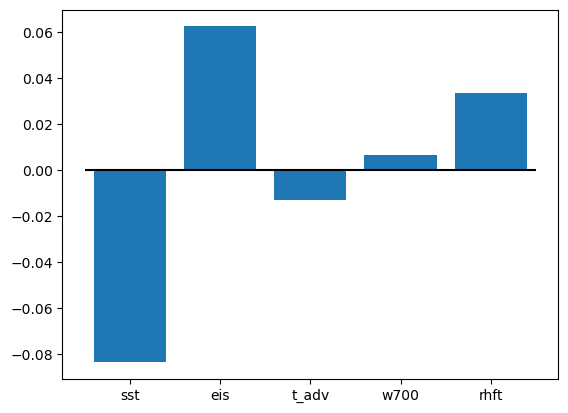

In [202]:
regr.fit(X_standardized,y)
plt.bar(np.arange(5), height = regr.coef_)
plt.hlines(0,-0.5,4.5, color='k')
plt.xticks(ticks=np.arange(5), labels = ['sst','eis','t_adv', 'w700', 'rhft'])
plt.show()

From the above bar graph, we can see that clf is highly positively correlated to eis and highly negatively correlated to sst. So both predictors - eis and sst could influence the sensitivity analysis. Therefore, both predictors are important.

---------------------------------------
--------------------------------------------


__Task__:
Use a machine learning model to 
1. Predict CLF as accurately as possible [low validation error (e.g. MSE or RMSE) and high explained variance (R²), tuning of hyperparameters]
2. Plot a scatter plot of observed CLF vs. model predicted CLF for the both training and test data sets to visualize model performance and check for overfitting. Do the same for a multiple linear regression model, is the machine learning model better than the multiple regression?
3. Which predictors are most important for the model to predict CLF? [feature importance]
3. Analyze the two most important meteorological features in more detail: How do they influence the prediction of CLF? [partial dependency, SHAP] 

In [474]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [487]:
#data preparation
X = data_df.drop(['clf'],axis=1)
y = data_df.drop(['sst','eis','w700','rhft','t_adv'],axis=1) 

# there is a function to split your data into training and test data sets in sklearn
from sklearn.model_selection import train_test_split

#Split the data into seperate training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [451]:
X_test.shape

(71, 5)

In [452]:
y_test.shape

(71, 1)

In [453]:
X.shape

(213, 5)

In [454]:
y.shape

(213, 1)

In [488]:
%%time

# fitting a GBRT model and use the algorithm provided by the sklearn package
from sklearn.ensemble import GradientBoostingRegressor

# assign the function to a variable name and train the model by calling the method model.fit() 
gbrt_model = GradientBoostingRegressor() # by not defining them here means keeping all GradientBoostingRegressor hyperparameters at the default values 
gbrt_model.fit(X_train, y_train)

CPU times: total: 125 ms
Wall time: 166 ms


GradientBoostingRegressor()

In [489]:
%%time

from sklearn.model_selection import RandomizedSearchCV
n_iter = 70
# here, we define the way the values for the RandomizedSearchCV are drawn for each specific hyperparameter that we want to tune
random_params = {'learning_rate': np.random.uniform(0,1,size = n_iter),
        'max_depth': np.random.randint(3, 10, n_iter),
        'n_estimators': np.random.randint(100, 500, n_iter),
        'subsample':np.random.uniform(0,1,size = n_iter),
        'min_samples_split': np.random.randint(3, 30, n_iter)
         }

# assign the function RandomizedSearchCV to a variable name and train the models in using hyperparameters set in the variable random by calling the method model.fit() 
searchcv = RandomizedSearchCV(gbrt_model, random_params, n_iter = n_iter, n_jobs = -1, verbose = 1, cv = 5)
searchcv.fit(X_train, y_train) # now get a coffee - this may take a while (~16 minutes on my laptop)
# one attribute of RandomizedSearchCV is "best_estimator_", which is the model instance with the combination of hyperparameter values that produced the best results in the cross validation 
best_gbrt_model = searchcv.best_estimator_

Fitting 5 folds for each of 70 candidates, totalling 350 fits
CPU times: total: 1.91 s
Wall time: 32.3 s


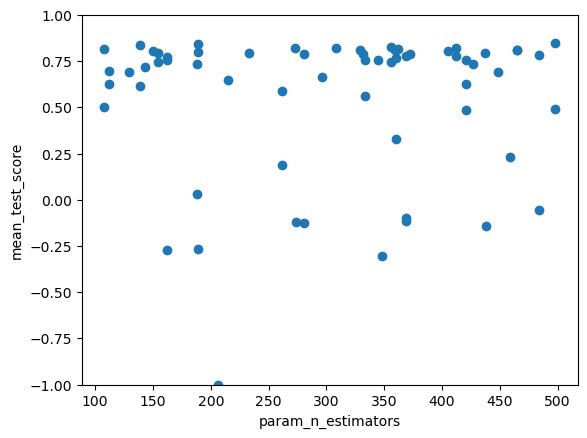

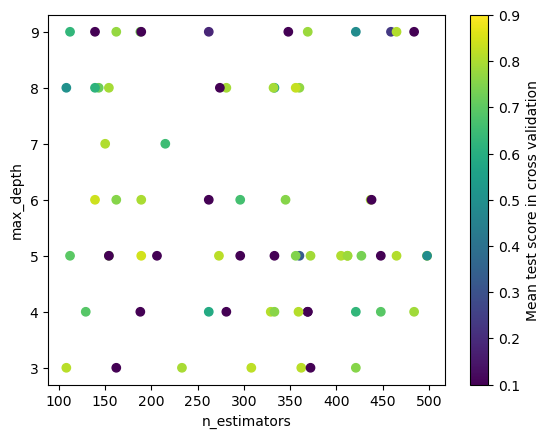

In [490]:
# store the mean test scores of the cross validation in the variable "scores" 
scores = searchcv.cv_results_["mean_test_score"]
# store the maximum depth used in each iteration cross validation in the variable "max_depth"
max_depth = searchcv.cv_results_["param_max_depth"]
# store the number of estimators used in each iteration of the cross validation in the variable "n_estimators"
n_estimators = searchcv.cv_results_["param_n_estimators"]

# you can visualize how a hyperparameter setting is related to the score
plt.scatter(n_estimators,scores)
plt.xlabel("param_n_estimators")
plt.ylabel("mean_test_score")
plt.ylim(-1,1)
plt.show()

# you can also visualize how two hyperparameter settings are related to the score at the same time
plt.scatter(n_estimators, max_depth, c=scores, vmin=0.1, vmax=0.9)
plt.xlabel('n_estimators'); plt.ylabel('max_depth')
plt.colorbar(label='Mean test score in cross validation')
plt.show()

learning_rate = searchcv.cv_results_["param_learning_rate"]
subsample = searchcv.cv_results_["param_subsample"]

GBRT mean squared error: 0.00
GBRT coefficient of determination: 0.83
GBRT coefficient of determination with the built-in method "score": 0.83


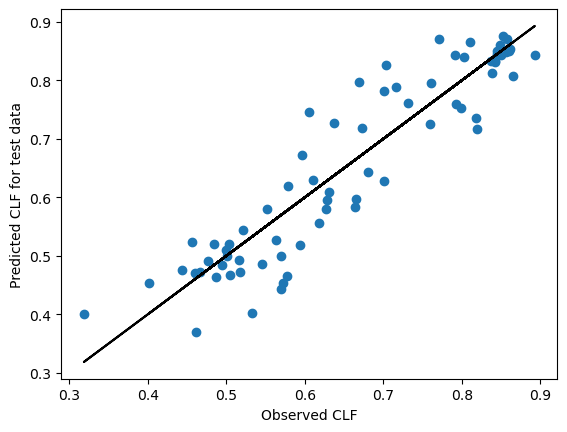

In [491]:
# Test the model using the independent test data

y_hat_gbrt = best_gbrt_model.predict(X_test) # using the optimized GBRT model

from sklearn.metrics import mean_squared_error, r2_score
print('GBRT mean squared error: %.2f' % mean_squared_error(y_test, y_hat_gbrt)) 
print('GBRT coefficient of determination: %.2f' % r2_score(y_test, y_hat_gbrt))
print('GBRT coefficient of determination with the built-in method "score": %.2f' % best_gbrt_model.score(X_test,y_test))

plt.scatter(y_test, y_hat_gbrt)
plt.xlabel("Observed CLF")
plt.ylabel("Predicted CLF for test data")
plt.plot(y_test, y_test, color = 'k')
plt.show()

GBRT mean squared error: 0.00
GBRT coefficient of determination: 0.99
GBRT coefficient of determination with the built-in method "score": 0.99


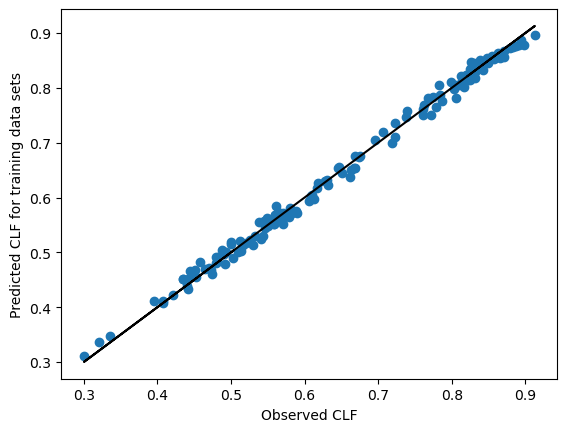

In [492]:
# Test the model using the training data sets

y_hat_gbrt = best_gbrt_model.predict(X_train) # using the optimized GBRT model

from sklearn.metrics import mean_squared_error, r2_score
print('GBRT mean squared error: %.2f' % mean_squared_error(y_train, y_hat_gbrt)) 
print('GBRT coefficient of determination: %.2f' % r2_score(y_train, y_hat_gbrt))
print('GBRT coefficient of determination with the built-in method "score": %.2f' % best_gbrt_model.score(X_train,y_train))

plt.scatter(y_train, y_hat_gbrt)
plt.xlabel("Observed CLF")
plt.ylabel("Predicted CLF for training data sets")
plt.plot(y_train, y_train, color = 'k')
plt.show()

## Check for Overfitting

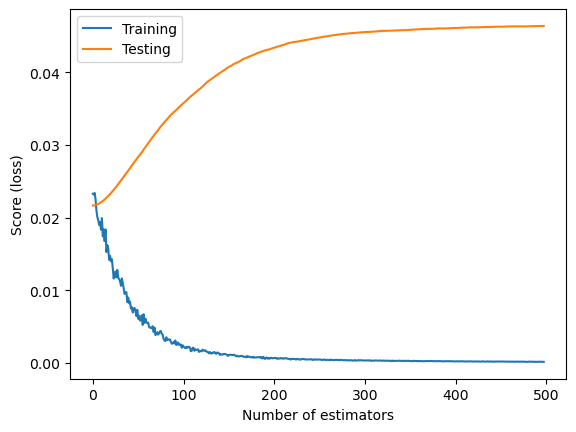

In [496]:
# y_test=y_test.values.reshape(71,1)

# Compute test score (train score is stored in the model output as the attribute "train_score_")
test_score = np.zeros([best_gbrt_model.n_estimators])
for i, y_hat in enumerate(best_gbrt_model.staged_predict(X_test)):
    test_score[i] = best_gbrt_model.loss_(y_test, y_hat)

# plot train and test scores
plt.plot(best_gbrt_model.train_score_, label='Training')
plt.plot(test_score, label='Testing')
plt.ylabel('Score (loss)')
plt.xlabel('Number of estimators')
plt.legend()
plt.show()

Here, the training score (loss) decreases significantly first and very slightly afterwards after ~ 250 trees, while the validation loss increases significantly and increases slightly after ~380 trees, it indicates overfitting.

## Multiple Linear Regression

In [497]:
#data preparation
X = data_df.drop(['clf'],axis=1)
y = data_df.drop(['sst','eis','w700','rhft','t_adv'],axis=1) 

In [508]:
X

,sst,eis,t_adv,w700,rhft
time,,,,,
2001-01-01,296.16850,4.824931,-1.682254,0.022467,35.642094
2001-02-01,297.11526,3.476827,-1.932790,0.026573,37.940147
2001-03-01,298.15900,2.265783,-2.199120,0.031560,33.834457
2001-04-01,298.17062,2.402812,-2.532412,0.039651,21.565330
2001-05-01,297.06927,3.534788,-2.962148,0.037318,7.997189
...,...,...,...,...,...
2020-06-01,295.68103,5.696461,-3.336127,0.031689,5.904962
2020-07-01,294.38498,6.359473,-2.678568,0.028419,6.503685
2020-09-01,292.41327,9.211763,-3.231832,0.036699,22.365800


In [509]:
y

,clf
time,
2001-01-01,0.663396
2001-02-01,0.605880
2001-03-01,0.529290
2001-04-01,0.464151
2001-05-01,0.318764
...,...
2020-06-01,0.516174
2020-07-01,0.563987
2020-09-01,0.865068


Linear model coefficient of determination with the built-in method "score": 0.80


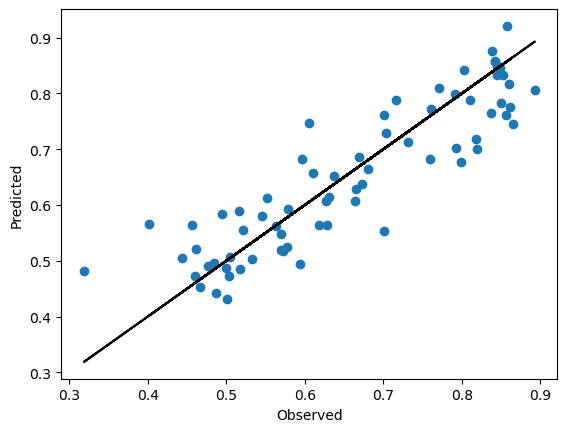

The multiple linear regression model explains 80% of the variability in cloud occurence and metrological data, whereas the GBRTs explain 84%


In [500]:
#Split the data into seperate training and test data sets
from sklearn.model_selection import train_test_split

# The output are train and test data sets for X and y. 
# test_size is typically between 0.2 and 0.5, depending on the data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

#Training the ML model, including hyperparameter tuning
from sklearn.linear_model import LinearRegression

# assign the function to a variable name and train the model by calling the method model.fit() 
linear_model = LinearRegression() 
linear_model.fit(X_train, y_train)

print('Linear model coefficient of determination with the built-in method "score": %.2f' % linear_model.score(X_test,y_test))

plt.scatter(y_test, linear_model.predict(X_test))
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.plot(y_test, y_test, color = 'k')
plt.show()

print('The multiple linear regression model explains 80% of the variability in cloud occurence and metrological data, whereas the GBRTs explain 84%')

-----------------------
## Part One - Task 3 - 3 - Which predictors are most important for the model to predict CLF? [feature importance]

In [523]:
# Here we print the permutation based feature importance 
print(best_gbrt_model.feature_importances_)

from sklearn.inspection import permutation_importance
pi = permutation_importance(best_gbrt_model, X_test, y_test, random_state=0)
print(pi.importances_mean)

[0.17069132 0.70280764 0.03940238 0.02886308 0.05823557]
[ 1.67601201e-01  8.99984025e-01  1.02444826e-02 -5.47904100e-04
  1.11486796e-01]


In [524]:
pi_df = pd.concat([
    pd.DataFrame(X.columns, columns=["name"]),
    pd.DataFrame(pi.importances_mean, columns=["values"])
    ], axis=1)

In [525]:
pi_df

,name,values
0,sst,0.167601
1,eis,0.899984
2,t_adv,0.010244
3,w700,-0.000548
4,rhft,0.111487


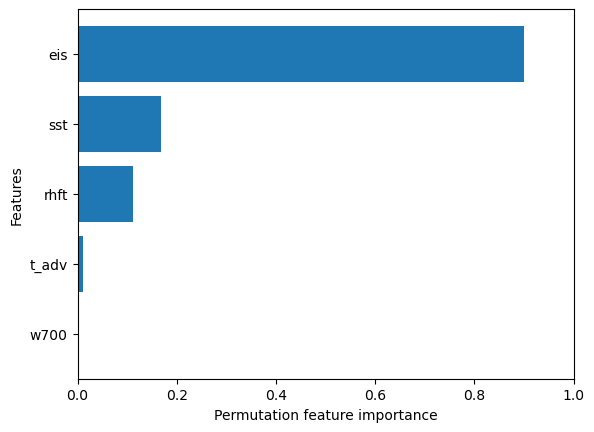

In [526]:
plt.barh(width = pi_df.sort_values("values")["values"], y = pi_df.sort_values("values")["name"])
plt.xlabel("Permutation feature importance")
plt.ylabel("Features")
plt.xlim(0,1)
plt.show()

From above bar chart, eis and sst are the most important predictors for the model to predict CLF, which can be visualized in above graph obtained by calculating the feature importances via permutation feature importance technique.

---------------------

## Part One - Task 3 - 4- Analyze the two most important meteorological features in more detail: How do they influence the prediction of CLF? [partial dependency, SHAP]

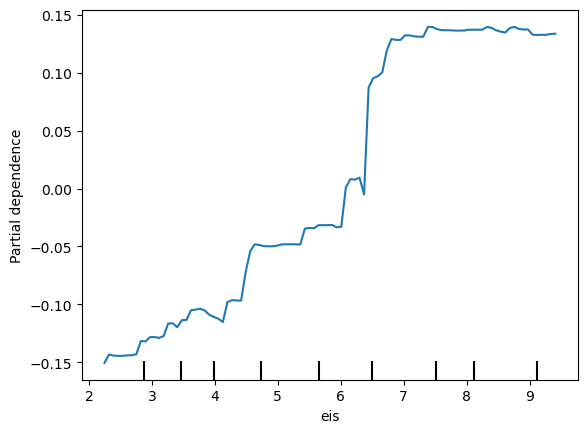

In [527]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(best_gbrt_model, X, features=["eis"], kind="average", n_jobs=-1,random_state=0)
plt.show()

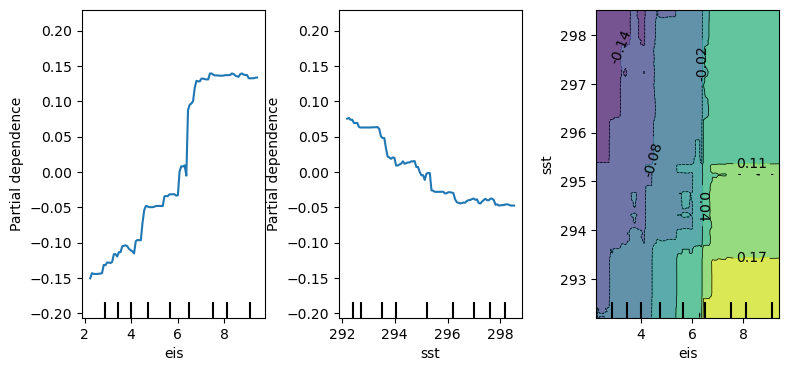

In [546]:
fig, ax = plt.subplots(ncols=3, figsize=(9, 4))
display = PartialDependenceDisplay.from_estimator(best_gbrt_model, X, features=["eis", "sst", ("eis", "sst")],
    kind=["average", "average", "average"], ax=ax)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

The partial dependencies plot of eis and sst shows the marginal effect of these features on the machine learnring model prediction.
- In the first plot from left, the averge model prediction of clf increases significantly before it gets lebelled off, when all the data points assume the feature value of eis.
- In the middle plot, the average model prediction decreases with the increase in sst values.
- The last plot from the left shows the correlation between eis and sst.

In [529]:
import shap

explainer = shap.TreeExplainer(best_gbrt_model) # use the fitted model as input here
shap_values = explainer.shap_values(X) # use the named X DataFrame

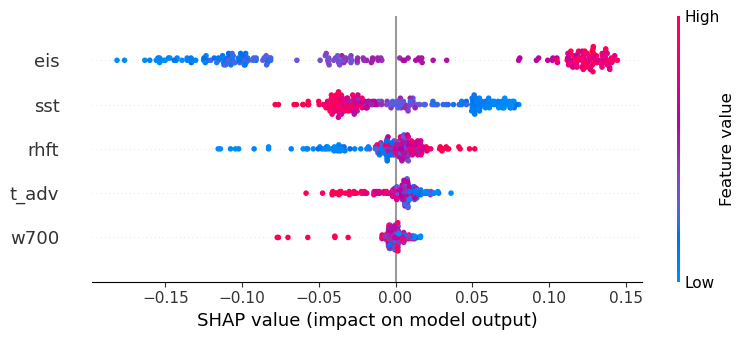

In [530]:
shap.summary_plot(shap_values, X)

- SHAP values quantify the contribution of each model feature to each specific model prediction. More precisely, SHAP values quantify the contribution of each model feature to the each model predictions deviation from the average model prediction.
- So, here the contribution of feature eis has high contribution to the prediction of clf from the average prediction of clf, as we can see the high and low shap values both for eis. This contribution is followed by eis.
- The positive and negative shap values of the feature depends on the feature's value and the average of the datasets.
- w700 has a low contribution to the model prediction for clf.
- Overall, in the summary plot, we see the first indications of the relationship between the value of a feature and the impact on the prediction.

Reference:
https://towardsdatascience.com/explainable-ai-xai-with-shap-multi-class-classification-problem-64dd30f97cea#:~:text=SHAP%20Force%20plot,prediction%20for%20a%20specific%20observation.

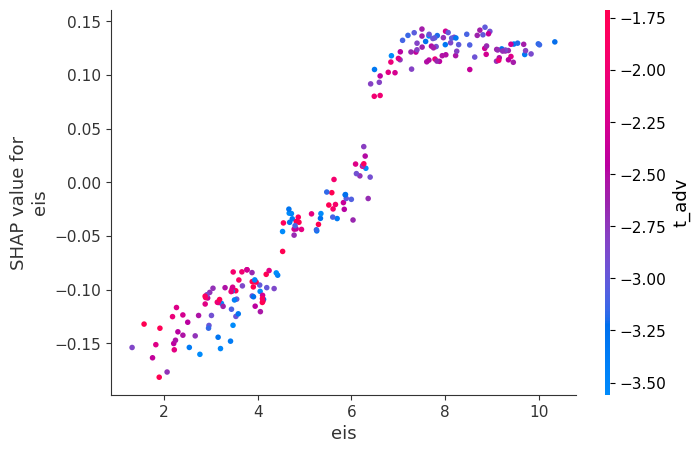

In [531]:
shap.dependence_plot("eis", shap_values, X)

- This shows how the model depends on the given feature.
- Vertical dispersion of the data points represents interaction effects of eis for the prediction of clf at the corresponding t_adv feature values.

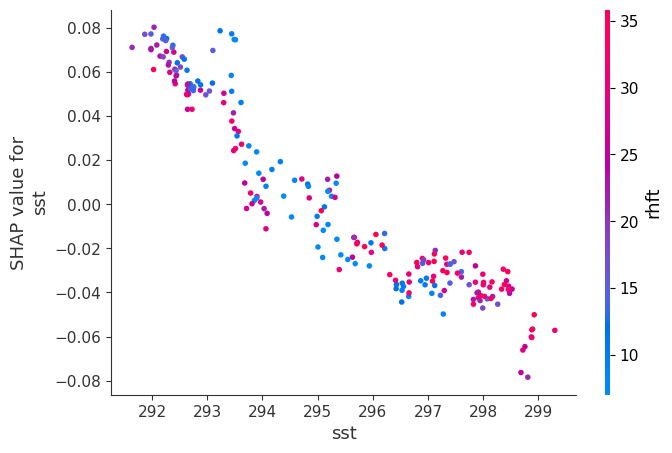

In [534]:
shap.dependence_plot("sst", shap_values, X)

- Vertical dispersion of the data points represents interaction effects of sst for the prediction of clf at the corresponding rhft feature values.

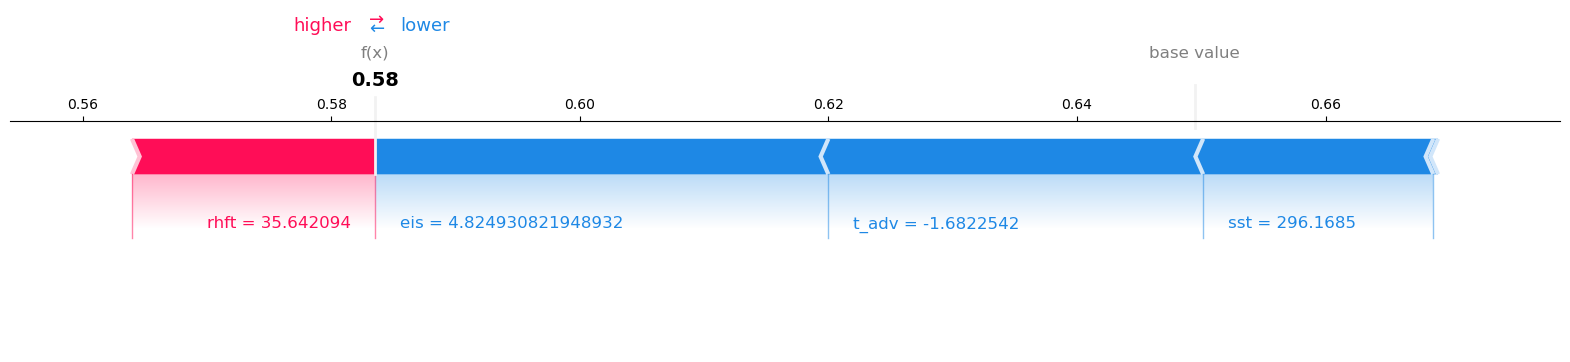

In [539]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0],matplotlib=True)

Forceplots are used to visualize the quantified contributions of each model feature to the prediction of a single data point (or observation).
Here, from this plot, we get to know that, 
- 0.58 is the model predict_proba value.
- 0.63 is the base value (average of the model output over the training datasets)
- The numbers on the plot arrows are the value of the feature for this instance. rhft = 35.642094 and sst = 296.1685
- Red represents features that pushed the model score higher, and blue representing features that pushed the score lower.
- The bigger the arrow, the bigger the impact of the feature on the output. The amount of decrease or increase in the impact can be seen on the x-axis.
- rhft of 35.642094 tends to increase the model output while eis of 4.82.......... values reduces the output value.

Reference:
https://towardsdatascience.com/explainable-ai-xai-with-shap-multi-class-classification-problem-64dd30f97cea#:~:text=SHAP%20Force%20plot,prediction%20for%20a%20specific%20observation.

## compare your findings with Klein et al. (2017), specifically Table 1 of that paper:

From paper, the influecnce of the diffeerent metrological predictors on the cloud layer fraction
- estimated inversion strength: Reduced mixing across inversion keeps boundary layer shallower, more humid and more cloudy
- temperature advection: Greater destabilization of the surface–atmosphere interface increases upward buoyancy flux promoting more clouds
- relative humidity in the free troposphere: Entrainment drying is reduced, thus moistening the boundary layer and increasing cloud
- sea surface temperature: Colder sea-surface temperature reduces the efficiency of entrainment necessitating more cloud to produce a given entrainment rate
- Wind Speed: Increased surface driven shear mixing increases latent heat flux and cloud

From our findings from multiple linear regression and sensitivity anallysis.
- increase in sst decreases clf (from partial dependenccy plot) which is in agreemnet with paper
- increase in eis increases clf prediction (from multiple regression) which is in agreement with the strengthened inversion stability that leads to more cloud.
- rhft and w700 has positive correlation with clf which is in consensuous  with the paper.
- t_adv has a negative correlation with clf which is in strong disagreemnt with the paper which supports that increased horizontal cold advenction increases cloud layer fraction.

------------------------------


## Part two: Classification in a remote sensing retrieval setting

__Task__
1. Divide data into test and training data sets
2. Train and optimize (hyperparameter tuning) a machine learning model 
3. Train a logistic regression model
4. Analyze both classifiers with a confusion matrix and perfomance metrics

In [595]:
import xarray as xr

data = xr.open_dataset('data_final_task_classification.nc') # load the data set
X = data[['IR_016','IR_039','IR_087','IR_097','IR_108','IR_120','IR_134']] # define X to be the satellite observations from different channels
X['hour'] = data.time['time.hour'] # use the hour of the observation as an additional predictor
X = X.to_dataframe() # convert to a pandas data frame
y = data.station_fls # define y to be the True/False labels from the meteorological station

In [567]:
data

<xarray.Dataset>
Dimensions:        (time: 10215)
Coordinates:
  * time           (time) datetime64[ns] 2017-01-01T02:15:00 ... 2017-12-31T2...
Data variables:
    IR_016         (time) float64 ...
    IR_039         (time) float64 ...
    IR_087         (time) float64 ...
    IR_097         (time) float64 ...
    IR_108         (time) float64 ...
    IR_120         (time) float64 ...
    IR_134         (time) float64 ...
    station_fls    (time) bool True True True True ... False False False False
    satellite_fls  (time) bool ...
Attributes:
    versionNumber:  1
    creator_name:   hx1567
    created_using:  $Id$
    date_created:   2017-12-01, 12:37

In [565]:
X

,IR_016,IR_039,IR_087,IR_097,IR_108,IR_120,IR_134,hour
time,,,,,,,,
2017-01-01 02:15:00,0.0,278.879608,280.685059,263.359650,282.301025,280.013031,263.040985,2
2017-01-01 02:45:00,0.0,278.679932,278.369781,261.783905,280.127319,277.147034,261.020630,2
2017-01-01 03:00:00,0.0,267.121002,267.075897,253.793442,267.948608,266.059509,255.240616,3
2017-01-01 03:15:00,0.0,259.046082,261.236359,249.466690,262.608582,262.083160,252.943909,3
2017-01-01 03:30:00,0.0,257.104797,258.599182,247.912064,259.713806,259.399933,251.122620,3
...,...,...,...,...,...,...,...,...
2017-12-31 22:30:00,0.0,280.978516,279.840820,262.733551,284.288177,285.683960,266.981049,22
2017-12-31 22:45:00,0.0,280.794678,279.597748,262.523621,284.006653,285.399597,267.776550,22
2017-12-31 23:00:00,0.0,280.422974,279.353851,262.523621,283.865631,284.971802,266.866974,23


In [566]:
y

<xarray.DataArray 'station_fls' (time: 10215)>
array([ True,  True,  True, ..., False, False, False])
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01T02:15:00 ... 2017-12-31T23:45:00

## 1. Divide data into test and training data sets

In [596]:
# first we split up the data in training and test as usual 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## 2. Logistic regression model

[[978 194]
 [414 457]]


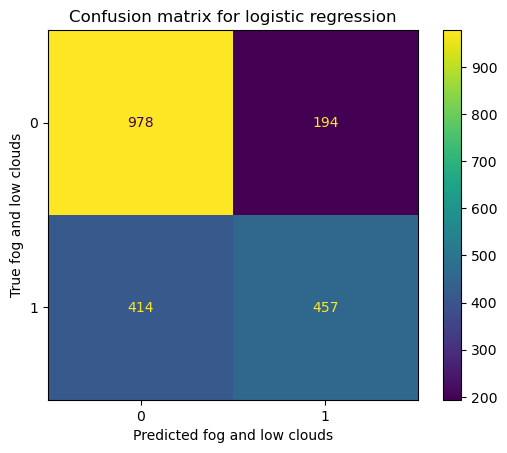

In [597]:
# we define the classifier to be a logistic regression 
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state = 0)
clf.fit(X_train, y_train) # ... and fit the model on the training data
y_pred = clf.predict(X_test) # we can make predictions on the test data

# To analyse the performance we can use a confusion matrix (see lecture slides)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
CM = confusion_matrix(y_test, y_pred)
print(CM) 

# we can also plot the confusion matrix using the function ConfusionMatrixDisplay 
disp = ConfusionMatrixDisplay(CM)
disp.plot()
plt.xlabel("Predicted fog and low clouds")
plt.ylabel("True fog and low clouds")
plt.title("Confusion matrix for logistic regression")
plt.show()

In [598]:
# From the confusion matrix, we can directly extract the information on the classification results and compute performance metrics of the classifier 

TN = CM[0][0] # True negative
FN = CM[1][0] # False negative
TP = CM[1][1] # True positive
FP = CM[0][1] # False positive

# Probability of detection, also: sensitivity, hit rate, recall, or true positive rate
POD = TP/(TP+FN)
# Overall accuracy, also percent correct (multiply by 100 to convert to %)
ACC = (TP+TN)/(TP+FP+FN+TN)
# False alarm rate
FAR = FP/(TP+FP)
# Bias score
BS = (TP+FP)/(TP+FN)

print("Probability of detection: ", round(POD,3))
print("Overall accuracy: ", round(ACC,3))
print("False alarm rate: ", round(FAR,3))
print("Bias score: ", round(BS,3))

Probability of detection:  0.525
Overall accuracy:  0.702
False alarm rate:  0.298
Bias score:  0.747


## 3. Machine Learning Model

--------------------------------------------------------
without hyperparameter tuning the gradient boosting classifier

[[1001  171]
 [ 254  617]]


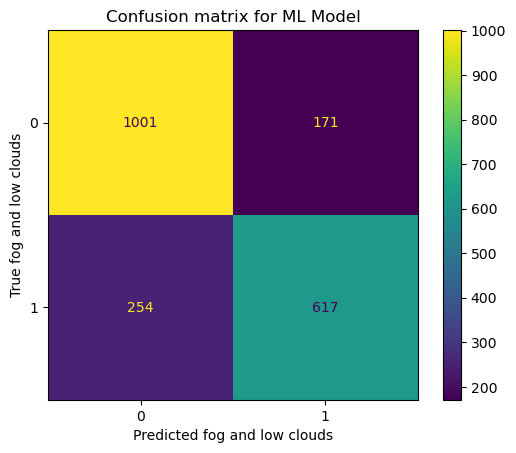

In [599]:
# we define the classifier to be a logistic regression 
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, 
                                 random_state=0).fit(X_train, y_train)
y_pred_ML = clf.predict(X_test)
CM = confusion_matrix(y_test, y_pred_ML)
print(CM)

# we can also plot the confusion matrix using the function ConfusionMatrixDisplay 
disp = ConfusionMatrixDisplay(CM)
disp.plot()
plt.xlabel("Predicted fog and low clouds")
plt.ylabel("True fog and low clouds")
plt.title("Confusion matrix for ML Model")
plt.show()

In [600]:
# From the confusion matrix, we can directly extract the information on the classification results and compute performance metrics of the classifier 

TN = CM[0][0] # True negative
FN = CM[1][0] # False negative
TP = CM[1][1] # True positive
FP = CM[0][1] # False positive

# Probability of detection, also: sensitivity, hit rate, recall, or true positive rate
POD = TP/(TP+FN)
# Overall accuracy, also percent correct (multiply by 100 to convert to %)
ACC = (TP+TN)/(TP+FP+FN+TN)
# False alarm rate
FAR = FP/(TP+FP)
# Bias score
BS = (TP+FP)/(TP+FN)

print("Probability of detection: ", round(POD,3))
print("Overall accuracy: ", round(ACC,3))
print("False alarm rate: ", round(FAR,3))
print("Bias score: ", round(BS,3))

Probability of detection:  0.708
Overall accuracy:  0.792
False alarm rate:  0.217
Bias score:  0.905


----------------------------

With hyperparameter tuning the gradient boosting classifier

In [601]:
%%time

# fitting a GBRT model and use the algorithm provided by the sklearn package
from sklearn.ensemble import GradientBoostingClassifier

# assign the function to a variable name and train the model by calling the method model.fit() 
gbct_model = GradientBoostingClassifier() # by not defining them here means keeping all GradientBoostingRegressor hyperparameters at the default values 
gbct_model.fit(X_train, y_train)

CPU times: total: 1.52 s
Wall time: 1.81 s


GradientBoostingClassifier()

In [602]:
%%time

from sklearn.model_selection import RandomizedSearchCV
n_iter = 70
# here, we define the way the values for the RandomizedSearchCV are drawn for each specific hyperparameter that we want to tune
random_params = {'learning_rate': np.random.uniform(0,1,size = n_iter),
        'max_depth': np.random.randint(3, 10, n_iter),
        'n_estimators': np.random.randint(100, 500, n_iter),
        'subsample':np.random.uniform(0,1,size = n_iter),
        'min_samples_split': np.random.randint(3, 30, n_iter)
         }

# assign the function RandomizedSearchCV to a variable name and train the models in using hyperparameters set in the variable random by calling the method model.fit() 
searchcv = RandomizedSearchCV(gbct_model, random_params, n_iter = n_iter, n_jobs = -1, verbose = 1, cv = 5)
searchcv.fit(X_train, y_train) 
# one attribute of RandomizedSearchCV is "best_estimator_", which is the model instance with the combination of hyperparameter values that produced the best results in the cross validation 
best_gbct_model = searchcv.best_estimator_

Fitting 5 folds for each of 70 candidates, totalling 350 fits
CPU times: total: 4.81 s
Wall time: 8min 8s


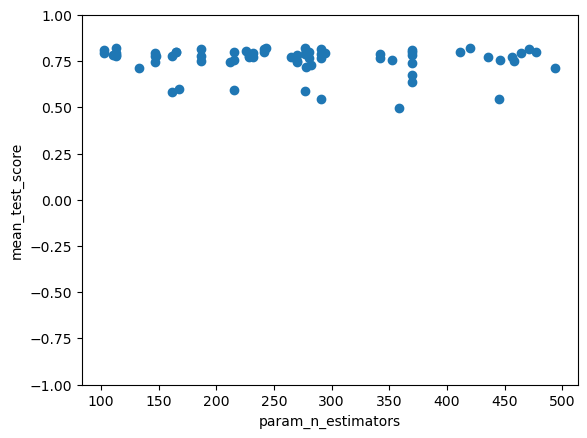

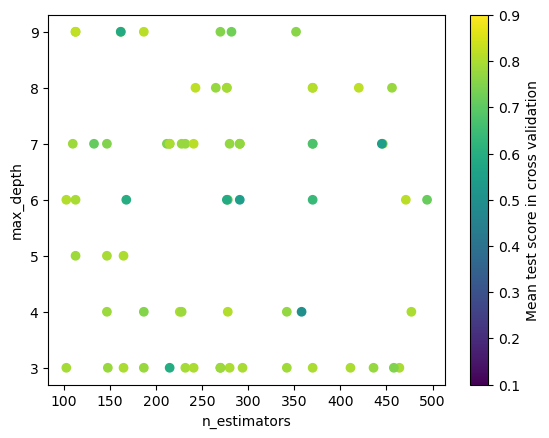

In [603]:
# store the mean test scores of the cross validation in the variable "scores" 
scores = searchcv.cv_results_["mean_test_score"]
# store the maximum depth used in each iteration cross validation in the variable "max_depth"
max_depth = searchcv.cv_results_["param_max_depth"]
# store the number of estimators used in each iteration of the cross validation in the variable "n_estimators"
n_estimators = searchcv.cv_results_["param_n_estimators"]

# you can visualize how a hyperparameter setting is related to the score
plt.scatter(n_estimators,scores)
plt.xlabel("param_n_estimators")
plt.ylabel("mean_test_score")
plt.ylim(-1,1)
plt.show()

# you can also visualize how two hyperparameter settings are related to the score at the same time
plt.scatter(n_estimators, max_depth, c=scores, vmin=0.1, vmax=0.9)
plt.xlabel('n_estimators'); plt.ylabel('max_depth')
plt.colorbar(label='Mean test score in cross validation')
plt.show()

learning_rate = searchcv.cv_results_["param_learning_rate"]
subsample = searchcv.cv_results_["param_subsample"]

[[1046  126]
 [ 197  674]]


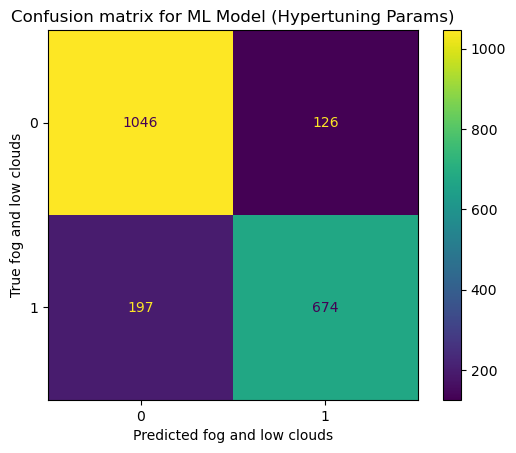

In [604]:
# Test the model using the independent test data

y_pred_ML_hp = best_gbct_model.predict(X_test) # using the optimized GBCT model
# To analyse the performance we can use a confusion matrix (see lecture slides)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
CM = confusion_matrix(y_test, y_pred_ML_hp)
print(CM)
# we can also plot the confusion matrix using the function ConfusionMatrixDisplay 
disp = ConfusionMatrixDisplay(CM)
disp.plot()
plt.xlabel("Predicted fog and low clouds")
plt.ylabel("True fog and low clouds")
plt.title("Confusion matrix for ML Model (Hypertuning Params)")
plt.show()

In [605]:
# From the confusion matrix, we can directly extract the information on the classification results and compute performance metrics of the classifier 

TN = CM[0][0] # True negative
FN = CM[1][0] # False negative
TP = CM[1][1] # True positive
FP = CM[0][1] # False positive

# Probability of detection, also: sensitivity, hit rate, recall, or true positive rate
POD = TP/(TP+FN)
# Overall accuracy, also percent correct (multiply by 100 to convert to %)
ACC = (TP+TN)/(TP+FP+FN+TN)
# False alarm rate
FAR = FP/(TP+FP)
# Bias score
BS = (TP+FP)/(TP+FN)

print("Probability of detection: ", round(POD,3))
print("Overall accuracy: ", round(ACC,3))
print("False alarm rate: ", round(FAR,3))
print("Bias score: ", round(BS,3))

Probability of detection:  0.774
Overall accuracy:  0.842
False alarm rate:  0.158
Bias score:  0.918


 ## Descibe and compare the classification results of the machine learning and logistic regression approaches:

Classification Results:

Logistic Regression < Gradient Boosting Classiifer Without HyperParameter Tuning < Gradient Boosting Classiifer With HyperParameter Tuning 

## compare your results to the results in Andersen et al. (2018):

Andersen et al. (2018) applied an algorithm to detect spatial and temporal patterns of Namib-region Fog and low clouds (FLCs) and was validated against net radiation measurements at the FogNet station network located in the central Namib region. The algorithm shows:
- probability of detection: 0.94, My Results(ML HP tuning: 0.774, ML without HP tuning: 0.708, Logistic Regression: 0.525)
- false alarms rate: 0.12, My Results(ML with HP tuning: 0.158, ML without HP tuning: 0.217, Logistic Regression: 0.298)
- overall accuracy: 0.97, My Results(ML with HP tuning: 0.842, ML without HP tuning: 0.792, Logistic Regression: 0.702)